In [1]:
#Import all needed packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import collections
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import plot_roc_curve
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
#Set Working Directory
os.chdir("/Users/andreasabia/Documents/ESCP/Machine Learning With Python")
#Import data
data=pd.read_csv('train.csv')

In [3]:
#Exploring Data
print(data.head())
print(data.shape)

   label   id  visitTime  purchaseTime  hour          C1          C2  \
0     -1   37   19274330            -1     0  2569487005  1830830742   
1     -1   55   19274334            -1     0  3191875643   403381353   
2     -1  114   19274353            -1     0  2634604934   403381353   
3     -1  128   19274358            -1     0  2569487005   403381353   
4     -1  164   19274367            -1     0  2569487005   403381353   

           C3         C4          C5  ...  N4  N5  N6  N7  N8  N9  N10  \
0  4228834423  652481754  2967512603  ...   0   0   0   0   0   0    0   
1  1238330876  652481754  2967512603  ...   0   0   0   0   1   0    0   
2  1928325921  652481754  2967512603  ...   0   0   0   0   0   0    0   
3   296915027  652481754  2967512603  ...   0   0   0   0   0   0    0   
4   681762206  652481754  2967512603  ...   0   0   0   0   0   0    0   

          C10         C11         C12  
0   419316267  3617851689  4220791646  
1  1968545380  3831440054  1213938795  
2 

In [4]:
#Checking Data
for i in data.columns:
    print ("---- %s ---" % i)
    print (data[i].value_counts())

---- label ---
-1    31371
 1       57
Name: label, dtype: int64
---- id ---
399357    1
159399    1
525994    1
278189    1
448176    1
         ..
68628     1
590869    1
476883    1
5143      1
327680    1
Name: id, Length: 31428, dtype: int64
---- visitTime ---
19328699    6
19319226    6
19325796    5
19314062    5
19310993    5
           ..
19310525    1
19283902    1
19314623    1
19318721    1
19300352    1
Name: visitTime, Length: 24587, dtype: int64
---- purchaseTime ---
-1           31371
 19307708        1
 19319002        1
 19306613        1
 19298361        1
 19330955        1
 19318637        1
 19324431        1
 19295049        1
 19331883        1
 19325720        1
 19344902        1
 19331996        1
 19325359        1
 19323160        1
 19327407        1
 19327835        1
 19323177        1
 19300350        1
 19344084        1
 19345863        1
 19312951        1
 19304723        1
 19335360        1
 19337379        1
 19302544        1
 19325069        1


In [5]:
#Checking for missing values
features=data
total = features.isnull().sum().sort_values(ascending=False)
percent_1 = features.isnull().sum()/features.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(6)

,Total,%
C12,0,0.0
C8,0,0.0
id,0,0.0
visitTime,0,0.0
purchaseTime,0,0.0
hour,0,0.0


Feature engineering

In [113]:
X=data.drop(["label","purchaseTime"], axis=1)
y=data['label']

In [114]:
X=X.drop(["C1","C12","C3","C11","C6","C10","C4","C5","id","N1","N2","N5","N7","hour","visitTime"], axis=1, errors="ignore")

In [8]:
#Dummifying columns, dropping the original and the first dummy
#X=pd.get_dummies(X, columns=["C7","C9","C8","C2"], drop_first=True)

In [115]:
to_normalize=["N9","N10","N8","N4","N3","N6"]
#For loop to normalize by min-max values
for i in to_normalize:
    x= X[[i]].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    X[i]=x_scaled

In [116]:
X.shape

(31428, 10)

In [117]:
X=X[to_normalize]

In [118]:
X.shape

(31428, 6)

Modeling

In [540]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.4, stratify=y)

In [541]:
# Over sampling followed by undersampling
print('Original dataset shape %s' % Counter(y_train))
sm=SMOTE(random_state=42, sampling_strategy=0.1)
X_res, y_res=sm.fit_resample(X_train,y_train)
cc = RandomUnderSampler(random_state=42, sampling_strategy=0.6)
X_res, y_res = cc.fit_resample(X_res,y_res)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({-1: 18822, 1: 34})
Resampled dataset shape Counter({-1: 3136, 1: 1882})


Logistic Regression

In [542]:
logmodel=LogisticRegression()
logmodel.fit(X_res,y_res)
predictions = logmodel.predict(X_test)

In [543]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

          -1       1.00      0.99      0.99     12549
           1       0.09      0.74      0.17        23

    accuracy                           0.99     12572
   macro avg       0.55      0.86      0.58     12572
weighted avg       1.00      0.99      0.99     12572



In [544]:
confusion_matrix(predictions,y_test)

array([[12385,     6],
       [  164,    17]])

Random Forest

In [571]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42, max_depth=1)
# Train the model on training data
rf.fit(X_res, y_res);

In [572]:
predictions = rf.predict(X_test)

In [573]:
confusion_matrix(predictions,y_test)

array([[12479,     3],
       [   70,    20]])

In [574]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

          -1       1.00      0.99      1.00     12549
           1       0.22      0.87      0.35        23

    accuracy                           0.99     12572
   macro avg       0.61      0.93      0.68     12572
weighted avg       1.00      0.99      1.00     12572



In [575]:
predictions = rf.predict(X_res)

In [576]:
confusion_matrix(predictions,y_res)

array([[3112,  260],
       [  24, 1622]])

In [577]:
print(classification_report(y_res,predictions))

              precision    recall  f1-score   support

          -1       0.92      0.99      0.96      3136
           1       0.99      0.86      0.92      1882

    accuracy                           0.94      5018
   macro avg       0.95      0.93      0.94      5018
weighted avg       0.95      0.94      0.94      5018



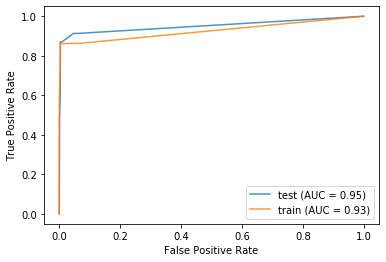

In [578]:
ax = plt.gca()
test_rf = plot_roc_curve(rf, X_test, y_test,ax=ax, alpha=0.8, name="test")
train_rf = plot_roc_curve(rf, X_res, y_res,ax=ax, alpha=0.8, name="train")
plt.show()

///////////////////////////////////////////////////////////////////////////
## CHOSEN MODEL
Gradient Boosting

In [499]:
#Setting parameters for optimal XGB
parameters = {'max_depth':[1,2,3],
              'learning_rate':[0.01,0.05,0.1,0.5],
              'gamma':[0,0.5,1],
             'n_estimators':[1,3,5,10,20],
             'subsample':[0.7,0.8],
             'colsample_bytree':[0.1,0.5,0.8],
             'early_stopping_rounds':[5]}

In [ ]:
from sklearn.model_selection import GridSearchCV
gb = xgb.XGBClassifier()
xg=GridSearchCV(gb, verbose=2,param_grid=parameters)
xg.fit(X_res, y_res)
predictions=xg.predict(X_test)

In [ ]:
xg.best_params_

In [589]:
from sklearn.ensemble import GradientBoostingClassifier

xg= xgb.XGBClassifier(objective='binary:logistic', max_depth=3, learning_rate=0.5, verbosity=1,\
                      gamma=0, n_estimators=20, subsample=0.7, colsample_bytree=0.5, early_stopping_rounds=5)
xg.fit(X_res, y_res)
predictions=xg.predict(X_test)

In [590]:
confusion_matrix(predictions,y_test)

array([[12503,     3],
       [   46,    20]])

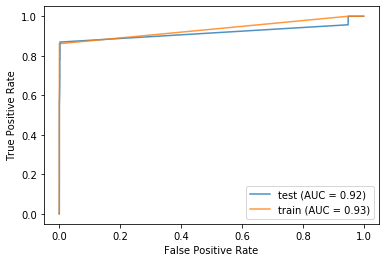

In [593]:
ax = plt.gca()
test_rf = plot_roc_curve(xg, X_test, y_test,ax=ax, alpha=0.8, name="test")
train_rf = plot_roc_curve(xg, X_res, y_res,ax=ax, alpha=0.8, name="train")
plt.show()

In [594]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     12549
           1       0.30      0.87      0.45        23

    accuracy                           1.00     12572
   macro avg       0.65      0.93      0.72     12572
weighted avg       1.00      1.00      1.00     12572



In [595]:
predictions=xg.predict(X_res)

In [596]:
print(classification_report(y_res,predictions))

              precision    recall  f1-score   support

          -1       0.92      1.00      0.96      3136
           1       1.00      0.86      0.92      1882

    accuracy                           0.95      5018
   macro avg       0.96      0.93      0.94      5018
weighted avg       0.95      0.95      0.95      5018



In [597]:
confusion_matrix(predictions,y_res)

array([[3132,  260],
       [   4, 1622]])

/////////////////////////////////////////////////////////////////////////////////////////

Other XGB models i did not end up using

In [35]:
model = xgb.XGBClassifier(max_depth=1)
eval_set = [(X_res, y_res), (X_test, y_test)]
model.fit(X_res, y_res, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)

[0]	validation_0-error:0.005959	validation_0-logloss:0.600112	validation_1-error:0.00472	validation_1-logloss:0.599378
[1]	validation_0-error:0.005959	validation_0-logloss:0.523892	validation_1-error:0.00472	validation_1-logloss:0.522503
[2]	validation_0-error:0.005959	validation_0-logloss:0.460322	validation_1-error:0.00472	validation_1-logloss:0.458343
[3]	validation_0-error:0.005959	validation_0-logloss:0.406558	validation_1-error:0.00472	validation_1-logloss:0.404075
[4]	validation_0-error:0.005959	validation_0-logloss:0.36064	validation_1-error:0.00472	validation_1-logloss:0.357764
[5]	validation_0-error:0.005959	validation_0-logloss:0.321072	validation_1-error:0.00472	validation_1-logloss:0.317901
[6]	validation_0-error:0.005959	validation_0-logloss:0.286748	validation_1-error:0.00472	validation_1-logloss:0.283305
[7]	validation_0-error:0.004529	validation_0-logloss:0.256788	validation_1-error:0.002174	validation_1-logloss:0.252958
[8]	validation_0-error:0.005959	validation_0-log

[69]	validation_0-error:0.004529	validation_0-logloss:0.017552	validation_1-error:0.001962	validation_1-logloss:0.008026
[70]	validation_0-error:0.003814	validation_0-logloss:0.017508	validation_1-error:0.001591	validation_1-logloss:0.007958
[71]	validation_0-error:0.003814	validation_0-logloss:0.017466	validation_1-error:0.001591	validation_1-logloss:0.007935
[72]	validation_0-error:0.003814	validation_0-logloss:0.017422	validation_1-error:0.001538	validation_1-logloss:0.007925
[73]	validation_0-error:0.003814	validation_0-logloss:0.017383	validation_1-error:0.001591	validation_1-logloss:0.007915
[74]	validation_0-error:0.003814	validation_0-logloss:0.017342	validation_1-error:0.001538	validation_1-logloss:0.007898
[75]	validation_0-error:0.003814	validation_0-logloss:0.017304	validation_1-error:0.001538	validation_1-logloss:0.007862
[76]	validation_0-error:0.003814	validation_0-logloss:0.017267	validation_1-error:0.001538	validation_1-logloss:0.007853
[77]	validation_0-error:0.003814

In [36]:
predictions = [round(value) for value in y_pred]

In [37]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.85%


In [38]:
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

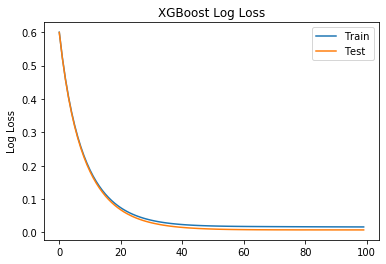

In [39]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

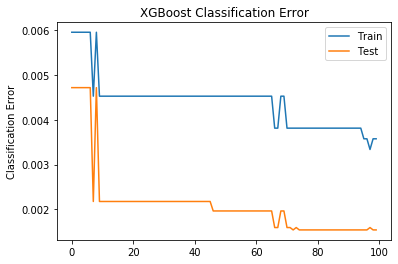

In [40]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [41]:
dTrain = xgb.DMatrix(X_res,label=y_res)
dTest = xgb.DMatrix(X_test)
dtrain = xgb.DMatrix(X_res)
dPred = xgb.DMatrix(X)

clf = xgb.train({'max_depth': 60, 'num_class': 1, \
                 'gamma': 10,'colsample_bytree': 0.4, 'subsample': 0.7,\
                 'num_round': 1, 'min_child_weight': 4, 'n_estimators': 1, \
                 'n_jobs': -1, 'learning_rate': 0.1, 'reg_alpha': 0.5},\
                dTrain, num_boost_round = 10)


/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [42]:
Y_pred = clf.predict(dTest)
cut=[]
for i in range(len(Y_pred)):
    if Y_pred[i]<0:
        cut.append(-1)
    else:
        cut.append(1)
print(classification_report(y_test,cut))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     18823
           1       0.38      0.68      0.48        34

    accuracy                           1.00     18857
   macro avg       0.69      0.84      0.74     18857
weighted avg       1.00      1.00      1.00     18857



In [43]:
Y_pred = clf.predict(dTrain)
cut=[]
for i in range(len(Y_pred)):
    if Y_pred[i]<0:
        cut.append(-1)
    else:
        cut.append(1)
print(classification_report(y_res,cut))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      4133
           1       0.82      0.81      0.81        62

    accuracy                           0.99      4195
   macro avg       0.91      0.90      0.91      4195
weighted avg       0.99      0.99      0.99      4195



Selecting features based on importance in Random forest

In [24]:
features_rf = {}
for A, B in zip(X.columns.to_numpy(), rf.feature_importances_):
    features_rf[A] = B
features_rf={k: round(v,3) for k, v in sorted(features_rf.items(), key=lambda item: item[1],reverse=True)}
features_rf

{'N9': 0.343,
 'N10': 0.263,
 'N8': 0.143,
 'N6': 0.125,
 'N3': 0.068,
 'N4': 0.029,
 'C7': 0.013,
 'C8': 0.009,
 'C9': 0.005,
 'C2': 0.002}

In [25]:
fit=[]
for key, value in features_rf.items():
    if float(value)>0.007:
        fit.append(key)

Now let's fit the model to the test dataset

In [598]:
tst=pd.read_csv('test1.csv')

In [599]:
tst

,label,id,visitTime,purchaseTime,hour,C1,C2,C3,C4,C5,...,N4,N5,N6,N7,N8,N9,N10,C10,C11,C12
0,-1,1,19360733,-1,0,2569487005,403381353,681762206,652481754,2967512603,...,0,0,0,0,0,0,0,2128770044,3617851689,4220791646
1,-1,2,19360734,-1,0,2416811818,1235983246,3653557526,652481754,2116767313,...,0,0,0,0,0,0,0,4256459078,2379633508,1284343215
2,-1,3,19360735,-1,0,3765056181,1235983246,1310333812,652481754,2116767313,...,0,0,0,0,0,0,0,2840358457,3831440054,1213938795
3,-1,4,19360737,-1,0,955802445,403381353,2290282995,652481754,2967512603,...,0,0,0,0,0,0,0,4039873369,535829057,3828748840
4,-1,5,19360752,-1,0,2569487005,2517724481,2463986301,2308170622,2967512603,...,0,0,0,0,0,0,0,907610626,3617851689,4220791646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32081,-1,32082,19446873,-1,23,2569487005,2018710401,887116886,652481754,2967512603,...,0,0,0,0,0,0,0,1546561973,3617851689,4220791646
32082,-1,32083,19446914,-1,23,2569487005,403381353,3475347077,652481754,2967512603,...,0,0,0,0,0,0,0,3227742820,3617851689,4220791646
32083,-1,32084,19446925,-1,23,2569487005,403381353,3475347077,652481754,2967512603,...,0,0,0,0,0,0,0,4069315994,3617851689,4220791646
32084,-1,32085,19446931,-1,23,2569487005,2541203883,448895441,2308170622,2967512603,...,0,0,0,0,0,0,0,2724771230,3617851689,4220791646


In [600]:
tst.label.value_counts()

-1    32086
Name: label, dtype: int64

In [601]:
identification=tst.id

In [602]:
to_normalize=["N9","N10","N8","N4","N3","N6"]
#For loop to normalize by min-max values
for i in to_normalize:
    x= tst[[i]].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    tst[i]=x_scaled

In [603]:
tst=tst[to_normalize]

In [604]:
a=tst.columns.tolist()
b=X.columns.tolist()
for i in range(len(a)):
    if a[i] in b:
        next
    else:
        print(a[i],"Not in list" )

In [605]:
#If number of features is not the same, use the above code to match, and then delete/ add if needed
print(X.shape)
print(tst.shape)

(31428, 6)
(32086, 6)


In [606]:
predictions = xg.predict(tst)
tst["label"]=predictions

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [607]:
tst.label.value_counts()

-1    31996
 1       90
Name: label, dtype: int64

In [608]:
tst

,N9,N10,N8,N4,N3,N6,label
0,0.0,0.0,0.0,0.0,0.0,0.0,-1
1,0.0,0.0,0.0,0.0,0.0,0.0,-1
2,0.0,0.0,0.0,0.0,0.0,0.0,-1
3,0.0,0.0,0.0,0.0,0.0,0.0,-1
4,0.0,0.0,0.0,0.0,0.0,0.0,-1
...,...,...,...,...,...,...,...
32081,0.0,0.0,0.0,0.0,0.0,0.0,-1
32082,0.0,0.0,0.0,0.0,0.0,0.0,-1
32083,0.0,0.0,0.0,0.0,0.0,0.0,-1
32084,0.0,0.0,0.0,0.0,0.0,0.0,-1


In [609]:
out=tst[["label"]]
out["id"]=identification

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [610]:
out

,label,id
0,-1,1
1,-1,2
2,-1,3
3,-1,4
4,-1,5
...,...,...
32081,-1,32082
32082,-1,32083
32083,-1,32084
32084,-1,32085


In [611]:
out.to_csv("/Users/andreasabia/Documents/ESCP/Machine Learning With Python/Output.csv")